## Introduction to Data Science

### Predictive Analysis - numerical data with regularization

#### Inspired by [this repo](https://github.com/Weesper1985/Predict_real_estate_prices), codes [here](https://www.kaggle.com/dhainjeamita/linear-regression/code), [here](https://www.kaggle.com/vikrishnan/house-sales-price-using-regression) and [here](https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/). Used [this data](https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime). Tried using [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html) techniques

In [1]:
import os
import sys
import time
import pickle
import itertools
import pandas as pd
import numpy as np
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 25, 25

from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.colors import LogNorm
import seaborn as sns
import pydotplus

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, ElasticNet
from sklearn.linear_model import lasso_path, enet_path
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score, validation_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz

#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"

##Turning GPU invisible
#os.environ["CUDA_VISIBLE_DEVICES"] = ""
#!export CUDA_VISIBLE_DEVICES=""
##Turning GPU visible again
#!unset CUDA_VISIBLE_DEVICES

import tensorflow as tf
from tensorflow.python.client import device_lib

import keras
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

from IPython.display import Image  

%matplotlib inline
#%matplotlib notebook
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Checking if we have a GPU
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4495078939789497560]

### Importing the datasets and exploring data

In [3]:
datapath = "../datasets/CSVs/"
outputs = "../outputs/"

In [4]:
! ls ../datasets/CSVs/communities.*

../datasets/CSVs/communities.data  ../datasets/CSVs/communities.names


In [5]:
! head -n10 ../datasets/CSVs/communities.names

Title: Communities and Crime

Abstract: Communities within the United States. The data combines socio-economic data 
from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime 
data from the 1995 FBI UCR.

-----------------------------------------------------------------------------------------

Data Set Characteristics:  Multivariate
Attribute Characteristics: Real


In [6]:
! head -n5 ../datasets/CSVs/communities.data

8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.9,0.12,0.17,0.34,0.47,0.29,0.32,0.2,1,0.37,0.72,0.34,0.6,0.29,0.15,0.43,0.39,0.4,0.39,0.32,0.27,0.27,0.36,0.41,0.08,0.19,0.1,0.18,0.48,0.27,0.68,0.23,0.41,0.25,0.52,0.68,0.4,0.75,0.75,0.35,0.55,0.59,0.61,0.56,0.74,0.76,0.04,0.14,0.03,0.24,0.27,0.37,0.39,0.07,0.07,0.08,0.08,0.89,0.06,0.14,0.13,0.33,0.39,0.28,0.55,0.09,0.51,0.5,0.21,0.71,0.52,0.05,0.26,0.65,0.14,0.06,0.22,0.19,0.18,0.36,0.35,0.38,0.34,0.38,0.46,0.25,0.04,0,0.12,0.42,0.5,0.51,0.64,0.03,0.13,0.96,0.17,0.06,0.18,0.44,0.13,0.94,0.93,0.03,0.07,0.1,0.07,0.02,0.57,0.29,0.12,0.26,0.2,0.06,0.04,0.9,0.5,0.32,0.14,0.2
53,?,?,Tukwilacity,1,0,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,0.02,1,0.31,0.72,0.11,0.45,0.25,0.29,0.39,0.29,0.37,0.38,0.33,0.16,0.3,0.22,0.35,0.01,0.24,0.14,0.24,0.3,0.27,0.73,0.57,0.15,0.42,0.36,1,0.63,0.91,1,0.29,0.43,0.47,0.6,0.39,0.46,0.53,0,0.24,0.01,0.52,0.62,0.64,0.63,0.25,0.27,0.25,0.23,0.84,0.1,0.16,0.1,0.17,0.29,0.17,0.26,0.2,0.82,0,0.02,0.79,0.24,0.02,0.25,0.65,0

In [7]:
names = open(os.path.join(datapath, 'communities.names'), 'r').readlines()
attributes = [n for n in names if n.startswith('@attribute')]
attributes = [a.split()[1] for a in attributes]
print(len(attributes))
print(attributes)

128
['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8', 'PctRecImmig10', 'PctSpeakEn

In [8]:
df = pd.read_csv(os.path.join(datapath, 'communities.data'), 
                 na_values='?', 
                 header=None, 
                 names=attributes)
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [9]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 128 columns):
state                    1994 non-null int64
county                   820 non-null float64
community                817 non-null float64
communityname            1994 non-null object
fold                     1994 non-null int64
population               1994 non-null float64
householdsize            1994 non-null float64
racepctblack             1994 non-null float64
racePctWhite             1994 non-null float64
racePctAsian             1994 non-null float64
racePctHisp              1994 non-null float64
agePct12t21              1994 non-null float64
agePct12t29              1994 non-null float64
agePct16t24              1994 non-null float64
agePct65up               1994 non-null float64
numbUrban                1994 non-null float64
pctUrban                 1994 non-null float64
medIncome                1994 non-null float64
pctWWage                 1994 non-null float64
pctWFa

In [10]:
#non numeric
columns1 = ['state', 'county', 'community', 'communityname', 'fold']

#many missing values
columns2 = ['LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'LemasSwFTFieldPerPop', 
            'LemasTotalReq',  'LemasTotReqPerPop', 'PolicReqPerOffic', 'PolicPerPop', 
            'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp', 
            'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz',
            'PolicAveOTWorked', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
            'LemasGangUnitDeploy', 'PolicBudgPerPop', 'OtherPerCap']

df.drop(columns=columns1, inplace=True)
df.drop(columns=columns2, inplace=True)

In [11]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 100 columns):
population               1994 non-null float64
householdsize            1994 non-null float64
racepctblack             1994 non-null float64
racePctWhite             1994 non-null float64
racePctAsian             1994 non-null float64
racePctHisp              1994 non-null float64
agePct12t21              1994 non-null float64
agePct12t29              1994 non-null float64
agePct16t24              1994 non-null float64
agePct65up               1994 non-null float64
numbUrban                1994 non-null float64
pctUrban                 1994 non-null float64
medIncome                1994 non-null float64
pctWWage                 1994 non-null float64
pctWFarmSelf             1994 non-null float64
pctWInvInc               1994 non-null float64
pctWSocSec               1994 non-null float64
pctWPubAsst              1994 non-null float64
pctWRetire               1994 non-null float64

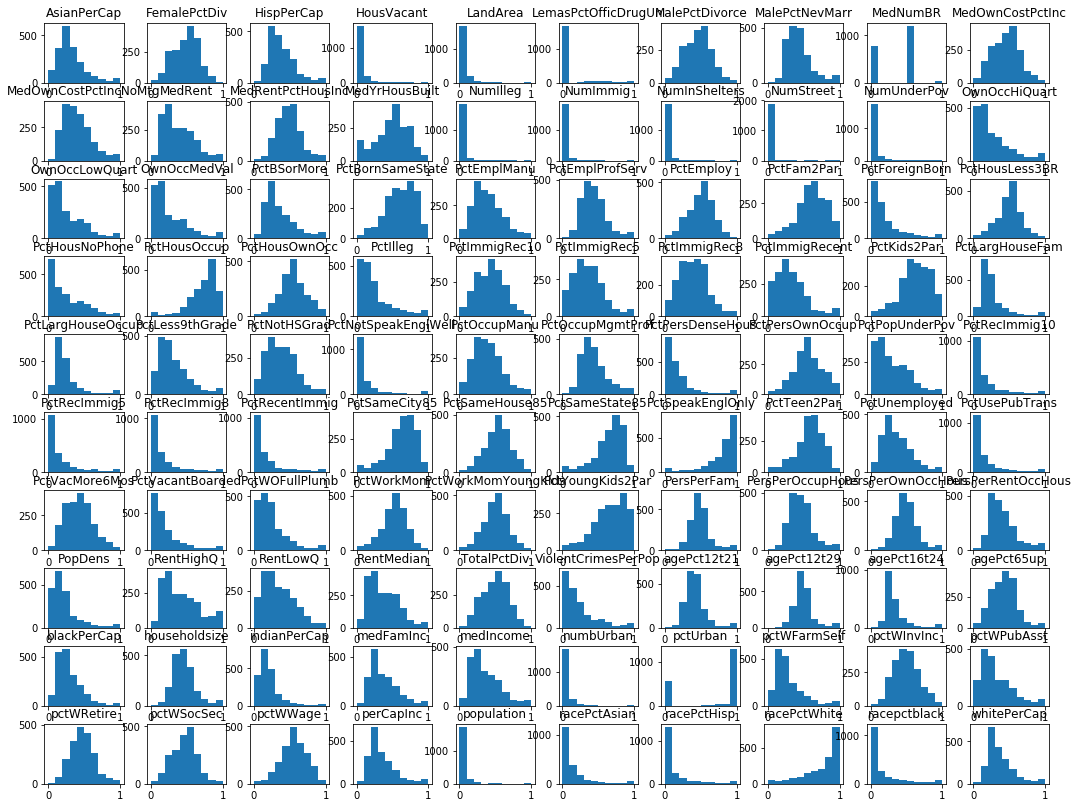

In [12]:
# histograms
df.hist(bins=10,figsize=(18,14),grid=False);

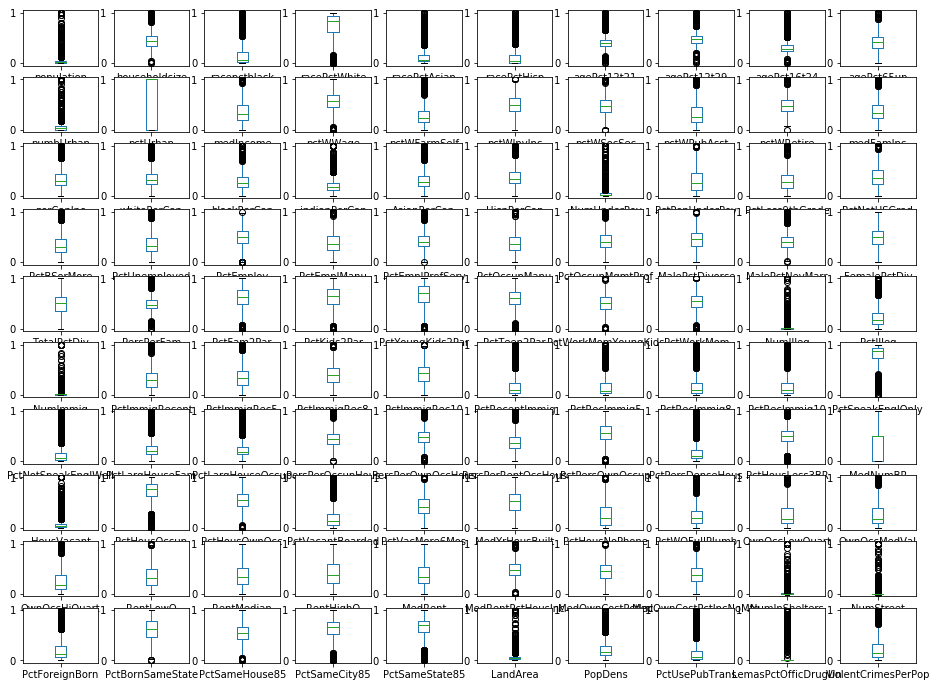

In [13]:
df.plot(kind='box', subplots=True, layout=(10,10), sharex=False, sharey=False, figsize=(16,12))
plt.show()

In [14]:
# correlation
pd.set_option('precision', 2)
df.corr(method='pearson')

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
population,1.00e+00,-4.61e-02,2.31e-01,-3.01e-01,1.82e-01,1.56e-01,6.37e-03,0.13,7.56e-02,-1.02e-01,...,1.73e-01,-0.13,-1.24e-01,1.61e-03,-8.96e-02,7.14e-01,2.32e-01,2.70e-01,4.66e-01,0.37
householdsize,-4.61e-02,1.00e+00,-6.71e-02,-2.36e-01,2.02e-01,4.69e-01,5.20e-01,0.37,2.95e-01,-6.13e-01,...,3.11e-01,-0.05,-5.78e-02,-1.03e-01,-3.28e-03,-1.51e-02,-4.07e-03,-5.15e-02,-9.44e-02,-0.03
racepctblack,2.31e-01,-6.71e-02,1.00e+00,-7.94e-01,-1.07e-01,-6.66e-02,1.22e-01,0.15,1.34e-01,5.29e-02,...,-9.81e-02,0.09,-4.56e-02,5.64e-02,-2.89e-03,1.50e-01,9.51e-02,1.47e-01,2.61e-01,0.63
racePctWhite,-3.01e-01,-2.36e-01,-7.94e-01,1.00e+00,-2.70e-01,-4.44e-01,-1.94e-01,-0.27,-1.84e-01,1.36e-01,...,-3.73e-01,0.11,1.65e-01,-1.97e-02,3.24e-02,-1.31e-01,-3.37e-01,-2.16e-01,-2.76e-01,-0.68
racePctAsian,1.82e-01,2.02e-01,-1.07e-01,-2.70e-01,1.00e+00,2.67e-01,-2.50e-02,0.10,5.28e-02,-2.72e-01,...,6.57e-01,-0.41,-1.90e-01,-1.95e-01,-1.98e-01,-1.08e-03,3.90e-01,2.97e-01,1.02e-01,0.04
racePctHisp,1.56e-01,4.69e-01,-6.66e-02,-4.44e-01,2.67e-01,1.00e+00,1.46e-01,0.21,8.63e-02,-2.28e-01,...,6.84e-01,-0.26,-1.66e-01,1.45e-02,2.02e-04,1.16e-02,3.70e-01,7.84e-02,1.25e-01,0.29
agePct12t21,6.37e-03,5.20e-01,1.22e-01,-1.94e-01,-2.50e-02,1.46e-01,1.00e+00,0.82,8.95e-01,-4.11e-01,...,-6.85e-02,0.08,-3.57e-01,-3.61e-01,-1.51e-01,2.57e-02,-9.57e-02,-1.73e-01,1.30e-03,0.06
agePct12t29,1.30e-01,3.67e-01,1.53e-01,-2.67e-01,1.01e-01,2.06e-01,8.22e-01,1.00,9.34e-01,-5.21e-01,...,7.77e-02,-0.05,-5.59e-01,-5.06e-01,-3.18e-01,6.25e-02,1.20e-01,-2.35e-02,1.17e-01,0.15
agePct16t24,7.56e-02,2.95e-01,1.34e-01,-1.84e-01,5.28e-02,8.63e-02,8.95e-01,0.93,1.00e+00,-3.23e-01,...,5.59e-03,-0.01,-4.63e-01,-4.79e-01,-2.75e-01,3.16e-02,4.60e-02,-4.04e-02,8.32e-02,0.10
agePct65up,-1.02e-01,-6.13e-01,5.29e-02,1.36e-01,-2.72e-01,-2.28e-01,-4.11e-01,-0.52,-3.23e-01,1.00e+00,...,-1.40e-01,0.15,3.94e-01,3.73e-01,2.56e-01,-1.24e-01,1.54e-02,6.79e-03,-1.02e-02,0.07


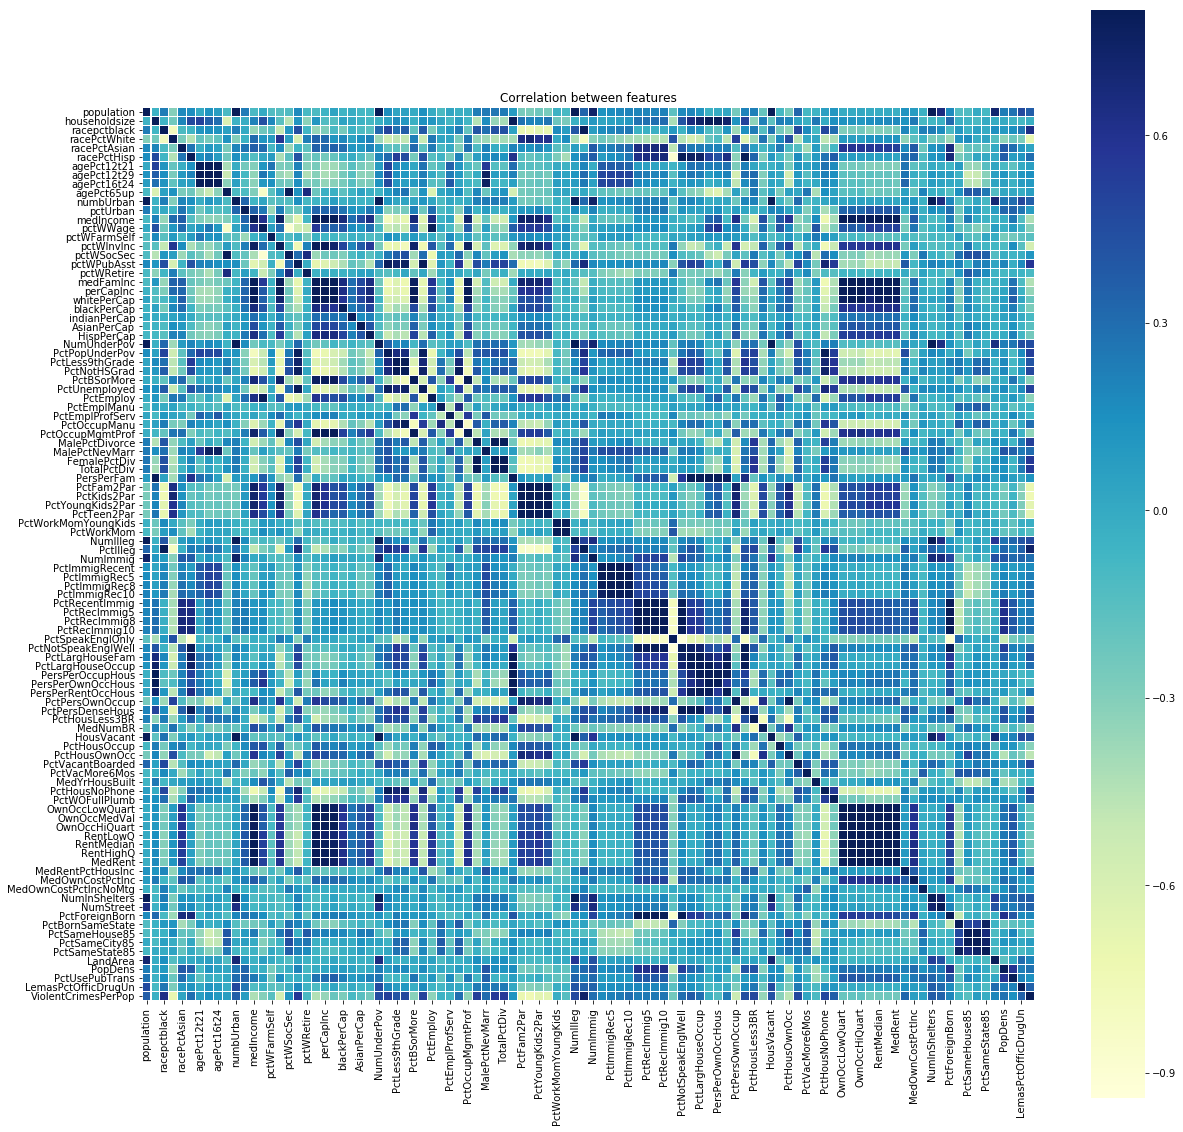

In [15]:
corr=df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, vmax=.8, linewidths=0.01,square=True,annot=False,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

In [16]:
crimes = df['ViolentCrimesPerPop']

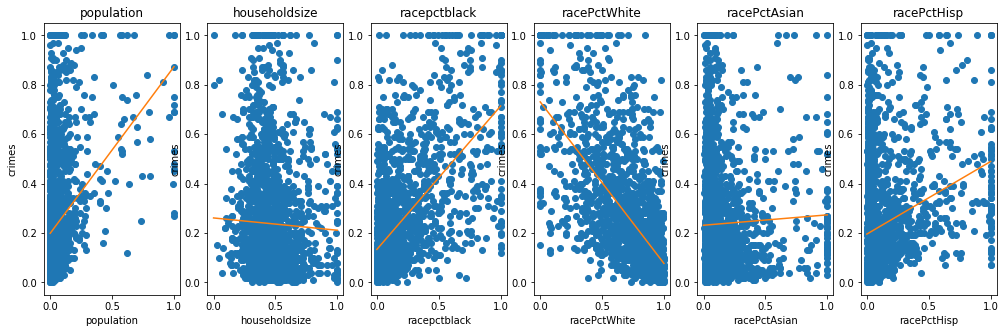

In [17]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[0:6]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

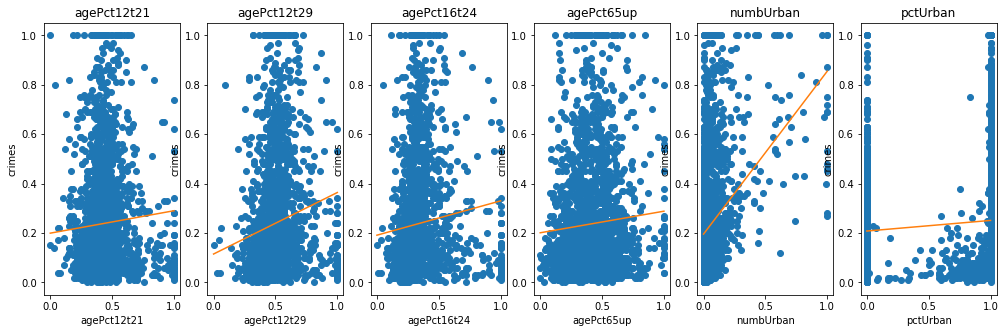

In [18]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[6:12]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

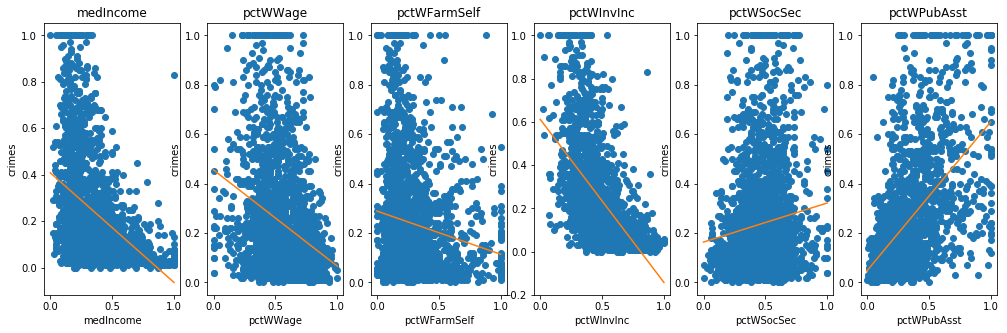

In [19]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[12:18]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

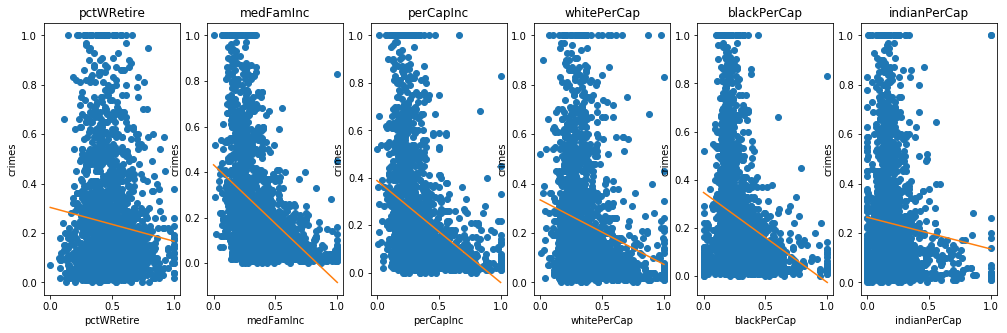

In [20]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[18:24]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

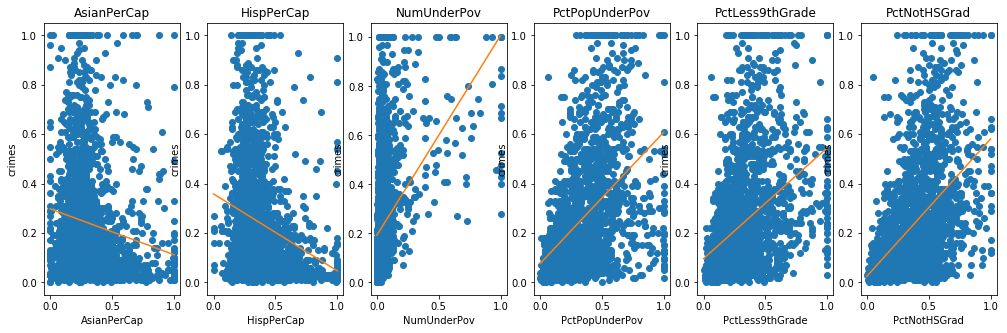

In [21]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[24:30]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

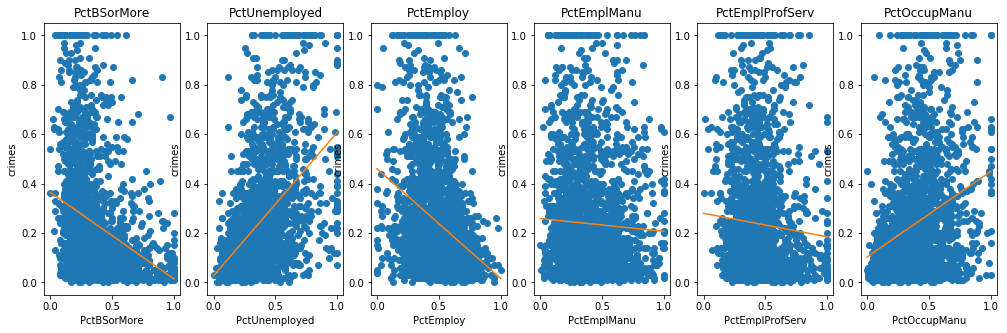

In [22]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[30:36]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

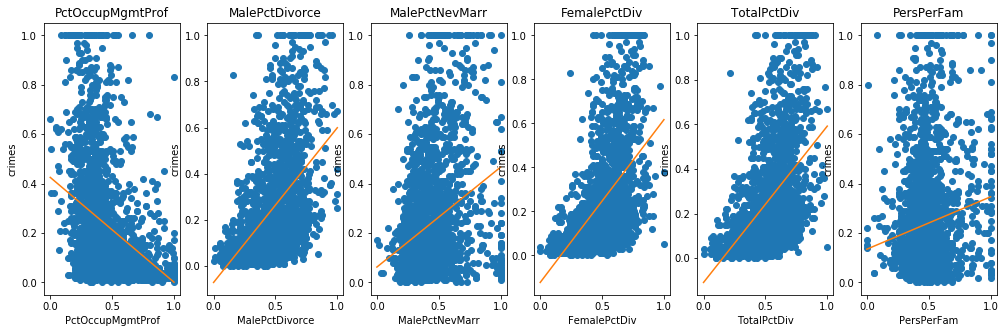

In [23]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[36:42]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

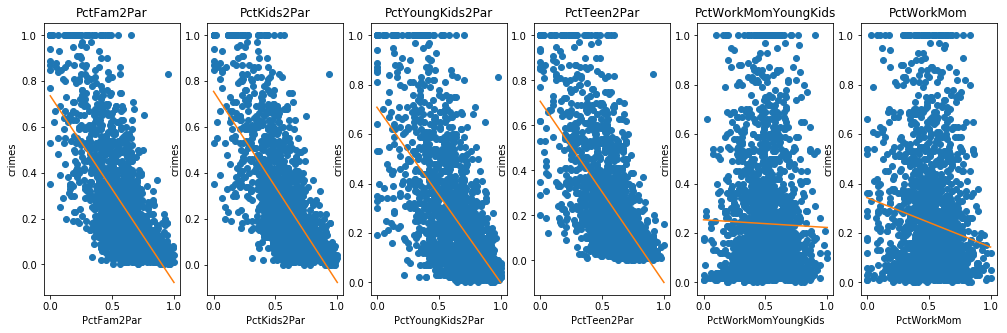

In [24]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[42:48]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

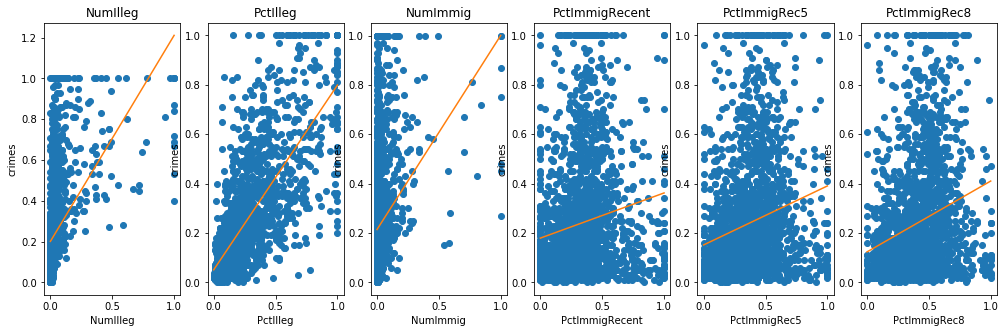

In [25]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[48:54]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

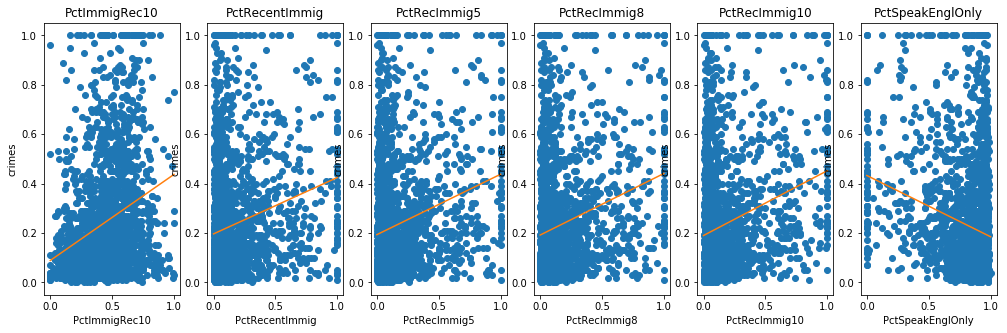

In [26]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[54:60]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

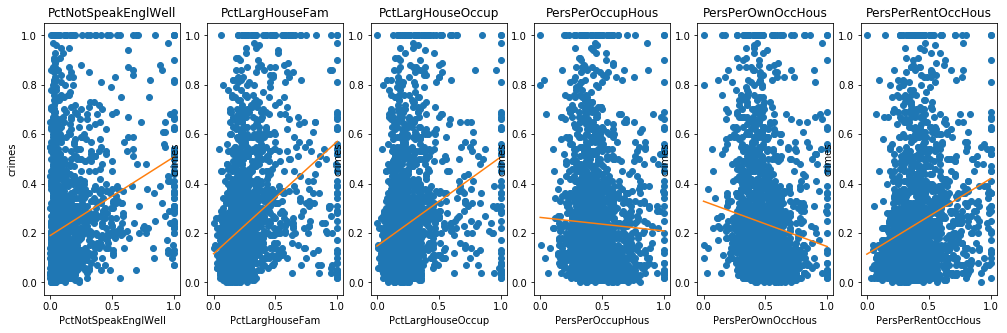

In [27]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[60:66]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

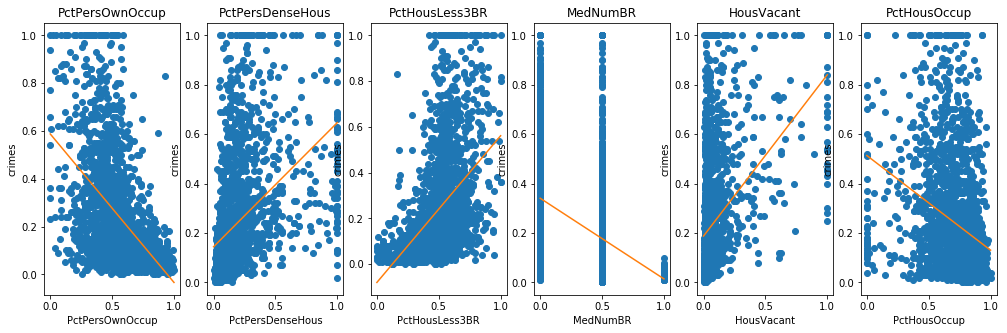

In [28]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[66:72]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

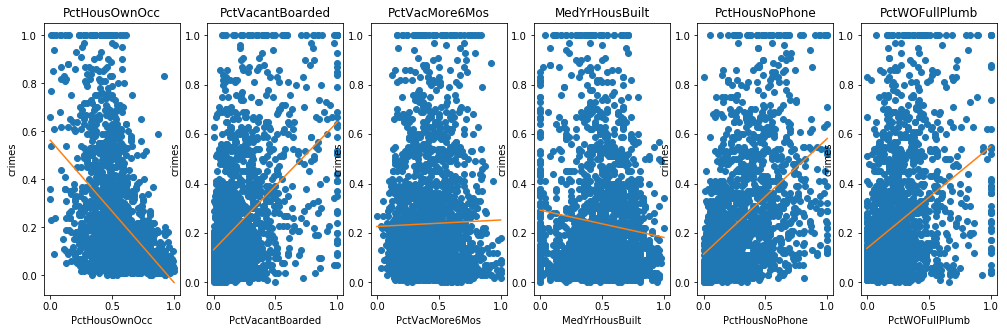

In [29]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[72:78]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

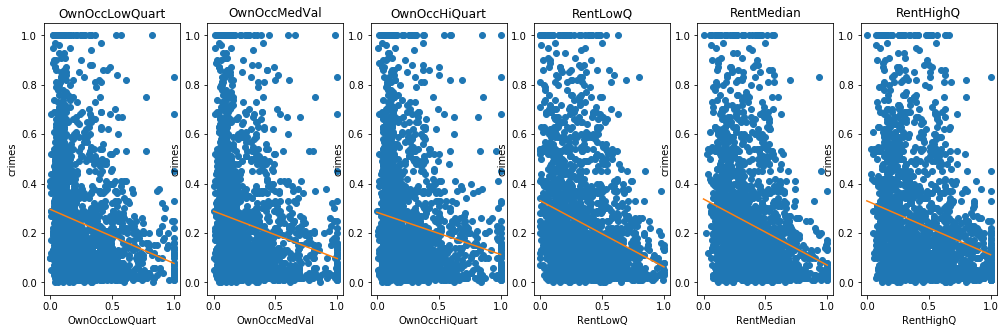

In [30]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[78:84]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

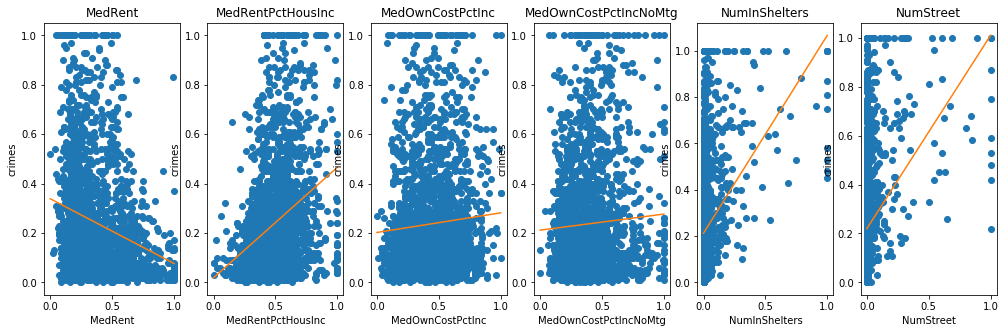

In [31]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[84:90]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

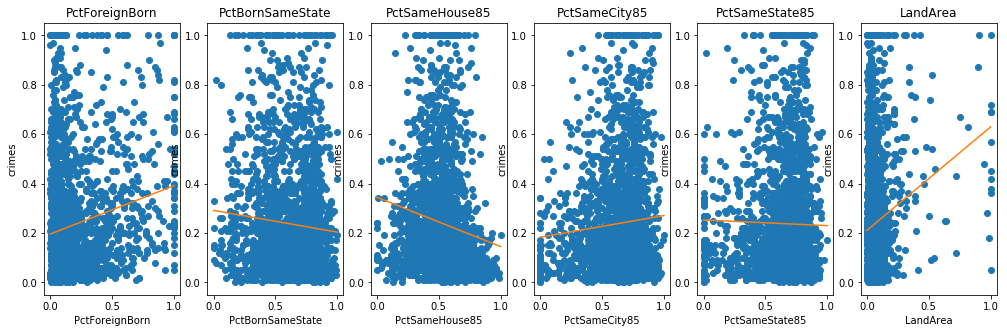

In [32]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[90:96]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

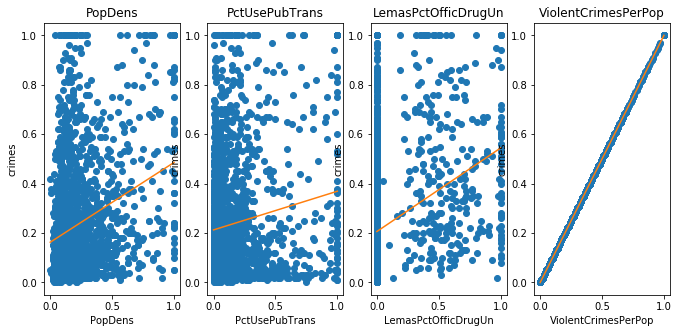

In [33]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(df.columns[96:]):
    plt.subplot(1, 7, i+1)
    x = df[col]
    y = crimes
    plt.plot(x, y, 'o')
    # Create regression line
    plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('crimes')

The point here is to test 'crimes' in a very lean way. 
We'll do this paying attention to: Histogram - Kurtosis and skewness. 
Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


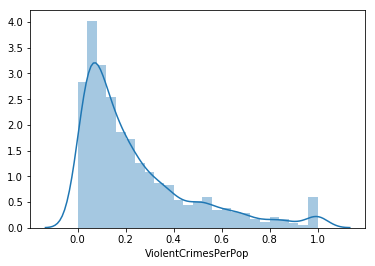

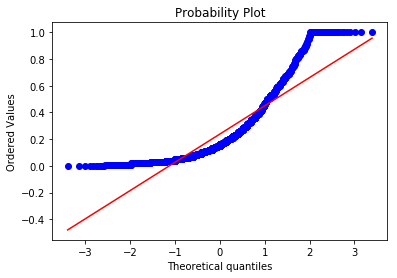

In [34]:
from scipy import stats
#histogram and normal probability plot
sns.distplot(crimes, hist=True);
fig = plt.figure()
res = stats.probplot(crimes, plot=plt)

### Preparing Data for predictions

In [35]:
# split into input (X) and output (Y) variables
X = df.values[:,0:-1]
y = df.values[:,99]

print(X.shape)
print(y.shape)

(1994, 99)
(1994,)


#### Split-out validation dataset

In [36]:
validation_size = 0.20
seed = 0
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [37]:
# Test options and evaluation metric using Root Mean Square error method
#http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

num_folds = 10
#score = 'neg_mean_squared_error'
score = 'r2'

#### Spot Check Algorithms

In [38]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('EN', ElasticNet(random_state=seed)))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('SVR', SVR()))
models.append(('RIDGE', Ridge(random_state=seed)))
models.append(('RIDGECV', RidgeCV()))
models.append(('MLPR', MLPRegressor(random_state=seed)))
models.append(('GPR', GaussianProcessRegressor(random_state=seed)))

In [39]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.642712 (0.042964)
LASSO: -0.019035 (0.020376)
EN: -0.019035 (0.020376)
KNN: 0.586496 (0.074766)
CART: 0.264208 (0.147164)
SVR: 0.650413 (0.035333)
RIDGE: 0.650887 (0.042516)
RIDGECV: 0.650887 (0.042516)
MLPR: 0.616472 (0.041546)
GPR: 0.516207 (0.053312)


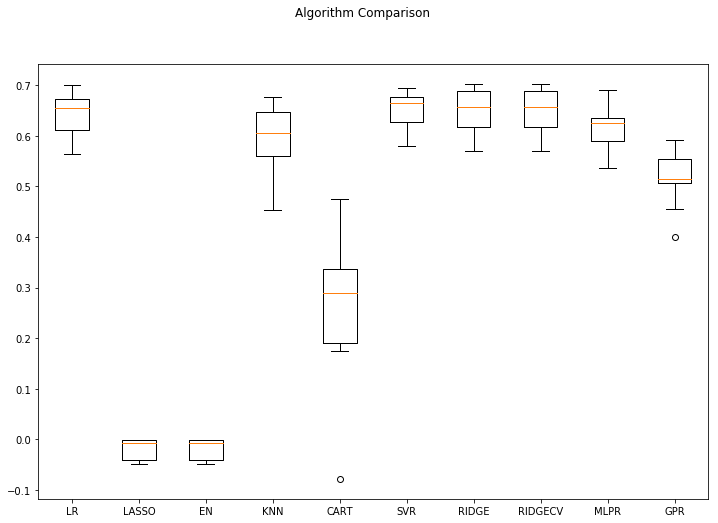

In [40]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Standardizing the dataset

In [41]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso(random_state=seed))])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet(random_state=seed))])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor(random_state=seed))])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge(random_state=seed))])))
pipelines.append(('ScaledRIDGECV', Pipeline([('Scaler', StandardScaler()),('RIDGECV', RidgeCV())])))
pipelines.append(('ScaledMLPR', Pipeline([('Scaler', StandardScaler()),('MLPR', MLPRegressor(random_state=seed))])))
pipelines.append(('ScaledGPR', Pipeline([('Scaler', StandardScaler()),('GPR', GaussianProcessRegressor(random_state=seed))])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.642712 (0.042964)
ScaledLASSO: -0.019035 (0.020376)
ScaledEN: -0.019035 (0.020376)
ScaledKNN: 0.583391 (0.062359)
ScaledCART: 0.273514 (0.158733)
ScaledSVR: 0.603515 (0.050501)
ScaledRIDGE: 0.644881 (0.043186)
ScaledRIDGECV: 0.649173 (0.043589)
ScaledMLPR: 0.149252 (0.169042)
ScaledGPR: -1.088153 (0.111529)


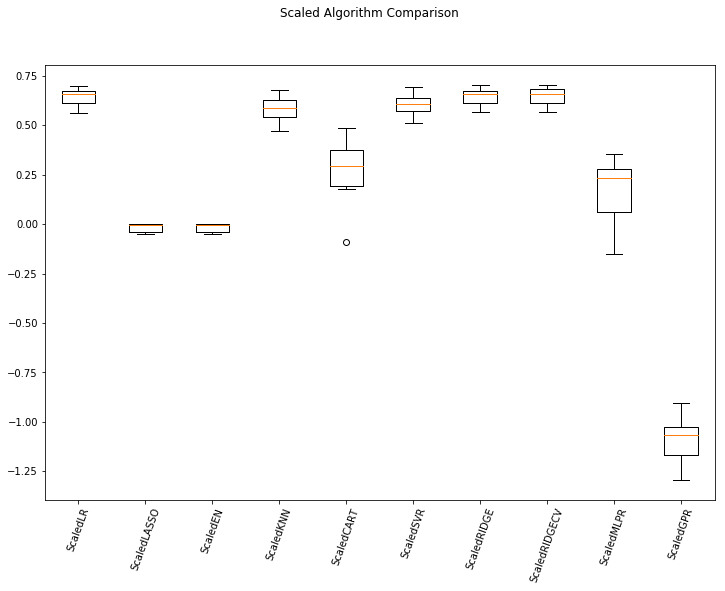

In [42]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=70)
plt.show()

### KNN Algorithm tuning

In [43]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.597728 using {'n_neighbors': 11}
0.369282 (0.096261) with: {'n_neighbors': 1}
0.572326 (0.062671) with: {'n_neighbors': 3}
0.582254 (0.064446) with: {'n_neighbors': 5}
0.588105 (0.056913) with: {'n_neighbors': 7}
0.594980 (0.050647) with: {'n_neighbors': 9}
0.597728 (0.045619) with: {'n_neighbors': 11}
0.596963 (0.043520) with: {'n_neighbors': 13}
0.596560 (0.040628) with: {'n_neighbors': 15}
0.596035 (0.038596) with: {'n_neighbors': 17}
0.596623 (0.037788) with: {'n_neighbors': 19}
0.594482 (0.034431) with: {'n_neighbors': 21}


### Regression Tree Algorithm tuning

In [78]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

min_samples_split_values = [2,3,4]
min_samples_leaf_values = [1,20,40,60,80]

param_grid = dict(min_samples_split=min_samples_split_values, min_samples_leaf=min_samples_leaf_values)
model = DecisionTreeRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.571862 using {'min_samples_leaf': 40, 'min_samples_split': 2}
0.274723 (0.155696) with: {'min_samples_leaf': 1, 'min_samples_split': 2}
0.248140 (0.147013) with: {'min_samples_leaf': 1, 'min_samples_split': 3}
0.277653 (0.127115) with: {'min_samples_leaf': 1, 'min_samples_split': 4}
0.529669 (0.042095) with: {'min_samples_leaf': 20, 'min_samples_split': 2}
0.529669 (0.042095) with: {'min_samples_leaf': 20, 'min_samples_split': 3}
0.529669 (0.042095) with: {'min_samples_leaf': 20, 'min_samples_split': 4}
0.571862 (0.037122) with: {'min_samples_leaf': 40, 'min_samples_split': 2}
0.571862 (0.037122) with: {'min_samples_leaf': 40, 'min_samples_split': 3}
0.571862 (0.037122) with: {'min_samples_leaf': 40, 'min_samples_split': 4}
0.555679 (0.039456) with: {'min_samples_leaf': 60, 'min_samples_split': 2}
0.555679 (0.039456) with: {'min_samples_leaf': 60, 'min_samples_split': 3}
0.555679 (0.039456) with: {'min_samples_leaf': 60, 'min_samples_split': 4}
0.546963 (0.037089) with: {'min_s

#### [Interpreting the Tree](http://blog.datadive.net/interpreting-random-forests/)

A Decision Tree is a tree (and a type of directed, acyclic graph) in which the nodes represent decisions (a square box), random transitions (a circular box) or terminal nodes, and the edges or branches are binary (yes/no, true/false) representing possible paths from one node to another. The specific type of decision tree used for machine learning contains no random transitions. To use a decision tree for classification or regression, one grabs a row of data or a set of features and starts at the root, and then through each subsequent decision node to the terminal node. The process is very intuitive and easy to interpret, which allows trained decision trees to be used for variable selection or more generally, feature engineering.

In [166]:
# https://github.com/andosa/treeinterpreter
from treeinterpreter import treeinterpreter as ti

In [94]:
sample = X_validation[100].reshape(-1, 1)
print(sample.shape)

(99, 1)


In [96]:
dt = DecisionTreeRegressor(random_state=seed,
                           min_samples_leaf=40,
                           min_samples_split=2).fit(rescaledX, Y_train)

prediction, bias, contributions = ti.predict(dt, sample.T)

In [98]:
ft_list = []
for i in range(len(sample.T)):
    #print("Sample", i)
    print("Bias (trainset mean)", bias[i])
    #print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], df.columns[:-1]), key=lambda x: -abs(x[0])):
       ft_list.append((feature, round(c, 2)))
    print("-"*50)

Bias (trainset mean) 0.23719749216300925
--------------------------------------------------


In [105]:
labels, values = zip(*ft_list[0:10])

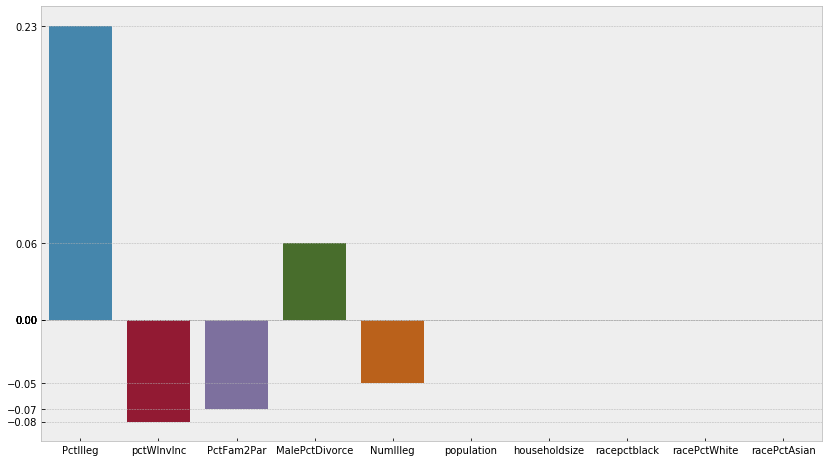

In [116]:
xs = np.arange(len(labels)) 

fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(xs, values, ax=ax)
#plt.bar(xs, values, align='center')
plt.xticks(xs, labels)
plt.yticks(values)
plt.show()

The TreeInterpreter library decomposes the predictions as the sum of contributions from each feature  
i.e. prediction = bias + feature(1)contribution + … + feature(n)contribution.  

In [118]:
prediction

array([0.3244186])

In [117]:
bias

array([0.23719749])

In [119]:
contributions

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.07895381,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.06320981,  0.        ,  0.        ,
         0.        ,  0.        , -0.07337223,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.05233015,  0.22866749,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

In [120]:
print(bias + np.sum(contributions, axis=1))

[0.3244186]


In [124]:
top50x = rescaledX[:50]
top5x = rescaledX[:5]
top50y = Y_train[:50]
top5y = Y_train[:5]

In [131]:
dt = DecisionTreeRegressor(random_state=seed,
                           min_samples_leaf=1,
                           min_samples_split=2).fit(top5x, top5y)

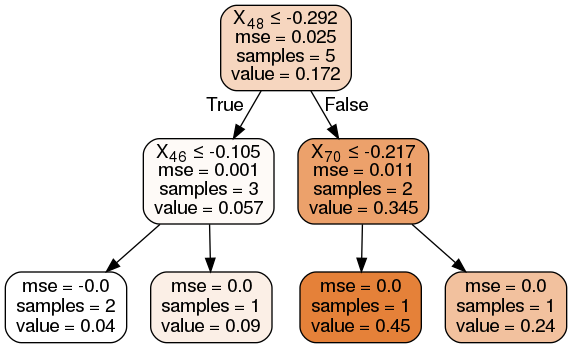

In [132]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Lasso Algorithm Tuning

In [45]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
alpha_values = np.linspace(0.0004,0.002,15)
param_grid = dict(alpha=alpha_values)
model = Lasso(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.649962 using {'alpha': 0.0012000000000000001}
0.649257 (0.043076) with: {'alpha': 0.0004}
0.649400 (0.042757) with: {'alpha': 0.0005142857142857143}
0.649441 (0.042247) with: {'alpha': 0.0006285714285714286}
0.649592 (0.041716) with: {'alpha': 0.000742857142857143}
0.649697 (0.041256) with: {'alpha': 0.0008571428571428572}
0.649797 (0.040846) with: {'alpha': 0.0009714285714285714}
0.649905 (0.040509) with: {'alpha': 0.0010857142857142858}
0.649962 (0.040106) with: {'alpha': 0.0012000000000000001}
0.649954 (0.039633) with: {'alpha': 0.0013142857142857144}
0.649919 (0.039104) with: {'alpha': 0.0014285714285714286}
0.649780 (0.038607) with: {'alpha': 0.001542857142857143}
0.649526 (0.038149) with: {'alpha': 0.0016571428571428572}
0.649202 (0.037773) with: {'alpha': 0.0017714285714285716}
0.648979 (0.037555) with: {'alpha': 0.001885714285714286}
0.648921 (0.037277) with: {'alpha': 0.002}


### Ridge Algorithm Tuning

In [46]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
alpha_values = [0, 1, 10, 20, 50, 80, 100, 120, 200, 500]
param_grid = dict(alpha=alpha_values)
model = Ridge(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.650883 using {'alpha': 50}
0.642715 (0.042962) with: {'alpha': 0}
0.644887 (0.043196) with: {'alpha': 1}
0.649181 (0.043623) with: {'alpha': 10}
0.650320 (0.043238) with: {'alpha': 20}
0.650883 (0.042105) with: {'alpha': 50}
0.650637 (0.041231) with: {'alpha': 80}
0.650391 (0.040738) with: {'alpha': 100}
0.650127 (0.040296) with: {'alpha': 120}
0.649042 (0.038866) with: {'alpha': 200}
0.645046 (0.035737) with: {'alpha': 500}


### ElasticNet Algorithm Tuning

In [47]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
l1_values = np.linspace(1e-07,1e-05, 15)
param_grid = dict(l1_ratio=l1_values)
model = ElasticNet(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.632986 using {'l1_ratio': 1e-07}
0.632986 (0.031958) with: {'l1_ratio': 1e-07}
0.632986 (0.031957) with: {'l1_ratio': 8.071428571428572e-07}
0.632985 (0.031956) with: {'l1_ratio': 1.5142857142857145e-06}
0.632984 (0.031955) with: {'l1_ratio': 2.2214285714285716e-06}
0.632983 (0.031955) with: {'l1_ratio': 2.9285714285714287e-06}
0.632982 (0.031954) with: {'l1_ratio': 3.6357142857142858e-06}
0.632981 (0.031953) with: {'l1_ratio': 4.342857142857143e-06}
0.632981 (0.031953) with: {'l1_ratio': 5.05e-06}
0.632980 (0.031952) with: {'l1_ratio': 5.7571428571428574e-06}
0.632979 (0.031951) with: {'l1_ratio': 6.464285714285715e-06}
0.632978 (0.031950) with: {'l1_ratio': 7.171428571428572e-06}
0.632977 (0.031950) with: {'l1_ratio': 7.878571428571429e-06}
0.632977 (0.031949) with: {'l1_ratio': 8.585714285714287e-06}
0.632976 (0.031948) with: {'l1_ratio': 9.292857142857144e-06}
0.632975 (0.031947) with: {'l1_ratio': 1e-05}


### MLP Algorithm Tunning

In [48]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

solver_values = ['lbfgs'] #, 'sgd', 'adam']
alpha_values = np.linspace(1e-5, 1e-4, 10)

param_grid = dict(solver=solver_values, alpha=alpha_values)
model = MLPRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)

#grid_result = grid.fit(rescaledX, Y_train)
grid_result = grid.fit(X_train, Y_train) #Without scaling, that seems not to improve model

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.555804 using {'alpha': 8e-05, 'solver': 'lbfgs'}
0.540824 (0.065387) with: {'alpha': 1e-05, 'solver': 'lbfgs'}
0.544512 (0.051145) with: {'alpha': 2e-05, 'solver': 'lbfgs'}
0.549054 (0.060809) with: {'alpha': 3.0000000000000004e-05, 'solver': 'lbfgs'}
0.537527 (0.068709) with: {'alpha': 4e-05, 'solver': 'lbfgs'}
0.546099 (0.062462) with: {'alpha': 5e-05, 'solver': 'lbfgs'}
0.541546 (0.064902) with: {'alpha': 6e-05, 'solver': 'lbfgs'}
0.554637 (0.053069) with: {'alpha': 7.000000000000001e-05, 'solver': 'lbfgs'}
0.555804 (0.066101) with: {'alpha': 8e-05, 'solver': 'lbfgs'}
0.544768 (0.069913) with: {'alpha': 9e-05, 'solver': 'lbfgs'}
0.541343 (0.063168) with: {'alpha': 0.0001, 'solver': 'lbfgs'}


### GPR Algorithm Tunning

In [49]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

alpha_values = np.linspace(1e-8, 1e-9, 6)
kernel_values = [1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),
                 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=2, noise_level_bounds=(1e-10, 1e+1))]

param_grid = dict(kernel=kernel_values, alpha=alpha_values)
model = GaussianProcessRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)

#grid_result = grid.fit(rescaledX, Y_train)
grid_result = grid.fit(X_train, Y_train) #Without scaling, that seems not to improve model

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.669451 using {'alpha': 1e-08, 'kernel': 1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=2)}
0.622005 (0.075196) with: {'alpha': 1e-08, 'kernel': 1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1)}
0.669451 (0.039263) with: {'alpha': 1e-08, 'kernel': 1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=2)}
0.622005 (0.075196) with: {'alpha': 8.2e-09, 'kernel': 1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1)}
0.669451 (0.039263) with: {'alpha': 8.2e-09, 'kernel': 1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=2)}
0.622005 (0.075196) with: {'alpha': 6.4e-09, 'kernel': 1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1)}
0.669451 (0.039263) with: {'alpha': 6.4e-09, 'kernel': 1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=2)}
0.622005 (0.075196) with: {'alpha': 4.6e-09, 'kernel': 1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1)}
0.669451 (0.039263) with: {'alpha': 4.6e-09, 'kernel': 1**2 * RBF(length_scale=100) + WhiteKernel(n

### Plotting the tunned algorithms

In [50]:
pipelines = []
pipelines.append(('Scaled LR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())])))
pipelines.append(('Scaled Opt LASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso(alpha=0.0012, random_state=seed))])))
pipelines.append(('Scaled Opt EN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet(l1_ratio=1e-07, random_state=seed))])))
pipelines.append(('Scaled Opt KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor(n_neighbors=11))])))
pipelines.append(('Scaled Opt CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor(min_samples_leaf=40,
                                                                                                           min_samples_split=3,
                                                                                                           random_state=seed))])))
pipelines.append(('Scaled SVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
pipelines.append(('Scaled Opt RIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE', Ridge(alpha=80, random_state=seed))])))
pipelines.append(('Scaled RIDGECV', Pipeline([('Scaler', StandardScaler()),('RIDGECV', RidgeCV())])))
pipelines.append(('Opt MLPR', Pipeline([('MLPR', MLPRegressor(alpha=5e-05, solver='lbfgs', random_state=seed))])))
pipelines.append(('Opt GPR', Pipeline([('GPR', GaussianProcessRegressor(alpha=1e-8, 
                                                                        kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
                                                                        + WhiteKernel(noise_level=2, noise_level_bounds=(1e-10, 1e+1)), 
                                                                        random_state=seed))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Scaled LR: 0.642712 (0.042964)
Scaled Opt LASSO: 0.649990 (0.040060)
Scaled Opt EN: 0.633067 (0.032087)
Scaled Opt KNN: 0.596825 (0.045275)
Scaled Opt CART: 0.571839 (0.037138)
Scaled SVR: 0.603515 (0.050501)
Scaled Opt RIDGE: 0.650641 (0.041172)
Scaled RIDGECV: 0.649173 (0.043589)
Opt MLPR: 0.546080 (0.062497)
Opt GPR: 0.669448 (0.039235)


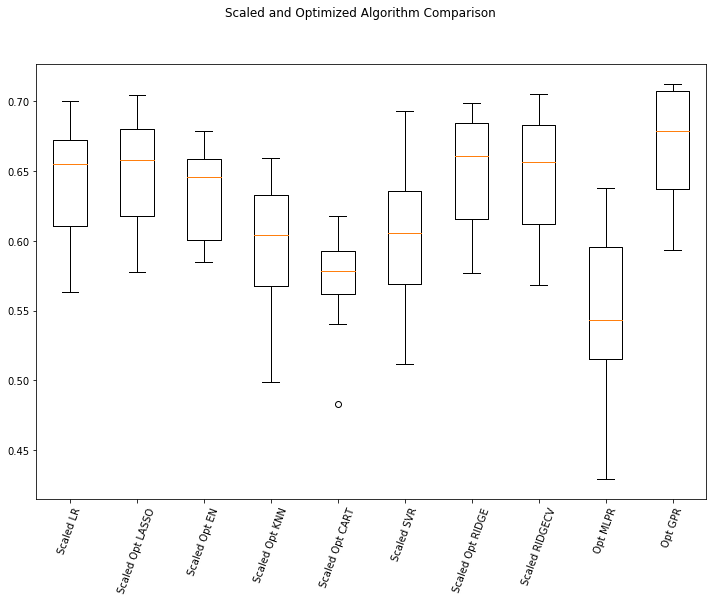

In [51]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Scaled and Optimized Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xticks(rotation=70)
plt.show()

### Ensembles

In [52]:
ensembles = []
ensembles.append(('Scaled AB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor(random_state=seed))])))
ensembles.append(('Scaled GBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor(random_state=seed))])))
ensembles.append(('Scaled RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(random_state=seed))])))
ensembles.append(('Scaled ET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(random_state=seed))])))
results_ensembles = []
names_ensembles = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results_ensembles.append(cv_results)
    names_ensembles.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Scaled AB: 0.470531 (0.079287)
Scaled GBM: 0.643885 (0.043359)
Scaled RF: 0.593808 (0.033479)
Scaled ET: 0.602481 (0.075530)


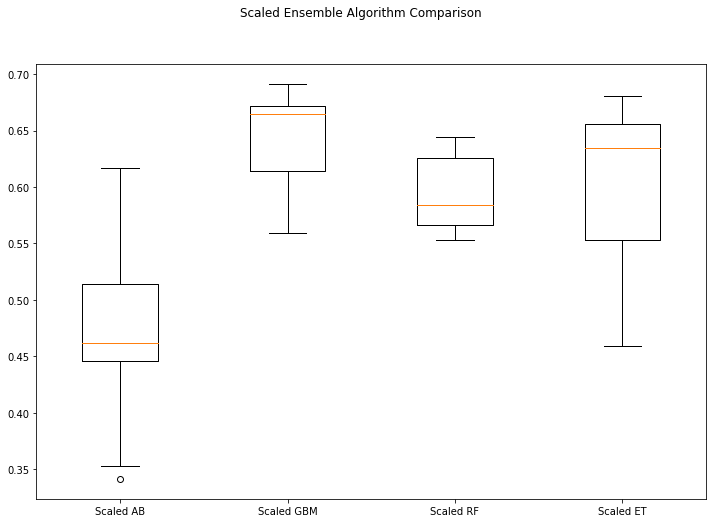

In [53]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_ensembles)
ax.set_xticklabels(names_ensembles)
plt.show()

### AdaBoost Algorithm Tuning

In [54]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([2,5,10,20,30,40]))
model = AdaBoostRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.582536 using {'n_estimators': 5}
0.511440 (0.068059) with: {'n_estimators': 2}
0.582536 (0.030732) with: {'n_estimators': 5}
0.579352 (0.042941) with: {'n_estimators': 10}
0.555142 (0.051459) with: {'n_estimators': 20}
0.515000 (0.057560) with: {'n_estimators': 30}
0.489318 (0.070065) with: {'n_estimators': 40}


### GBM Algorithm Tuning

In [55]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([20,35,40,45,50,55,60,100]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.644875 using {'n_estimators': 60}
0.618733 (0.030819) with: {'n_estimators': 20}
0.641796 (0.036673) with: {'n_estimators': 35}
0.643776 (0.038382) with: {'n_estimators': 40}
0.643930 (0.040308) with: {'n_estimators': 45}
0.644493 (0.041060) with: {'n_estimators': 50}
0.644323 (0.041551) with: {'n_estimators': 55}
0.644875 (0.040056) with: {'n_estimators': 60}
0.643898 (0.043618) with: {'n_estimators': 100}


### Random Forest Algorithm Tuning

In [56]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

n_estimators_values=np.array([30,50,70])
min_samples_split_values = [2,3]
min_samples_leaf_values = [10,20,30]

param_grid = dict(n_estimators=n_estimators_values,
                  min_samples_split=min_samples_split_values, 
                  min_samples_leaf=min_samples_leaf_values)

model = RandomForestRegressor(random_state=seed, n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.645711 using {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 10}
0.645711 (0.027864) with: {'n_estimators': 50, 'min_samples_split': 3, 'min_samples_leaf': 10}
0.639065 (0.025646) with: {'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 10}
0.636626 (0.024540) with: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 20}
0.637079 (0.025417) with: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 20}
0.637079 (0.025417) with: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 20}
0.645711 (0.027864) with: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 10}
0.645469 (0.028564) with: {'n_estimators': 70, 'min_samples_split': 2, 'min_samples_leaf': 10}
0.635309 (0.021704) with: {'n_estimators': 30, 'min_samples_split': 2, 'min_samples_leaf': 20}
0.645469 (0.028564) with: {'n_estimators': 70, 'min_samples_split': 3, 'min_samples_leaf': 10}
0.630090 (0.021958) with: {'n_estimators': 50, 'min_sam

In [133]:
rf = RandomForestRegressor(random_state=seed, 
                           n_jobs=-1,
                           n_estimators=50,
                           min_samples_leaf=1,
                           min_samples_split=2).fit(rescaledX, Y_train)

prediction, bias, contributions = ti.predict(rf, sample.T)

In [134]:
ft_list = []
for i in range(len(sample.T)):
    #print("Sample", i)
    print("Bias (trainset mean)", bias[i])
    #print("Feature contributions:")
    for c, feature in sorted(zip(contributions[i], df.columns[:-1]), key=lambda x: -abs(x[0])):
       ft_list.append((feature, round(c, 2)))
    print("-"*50)

Bias (trainset mean) 0.23680702194357375
--------------------------------------------------


In [139]:
labels, values = zip(*ft_list[0:15])

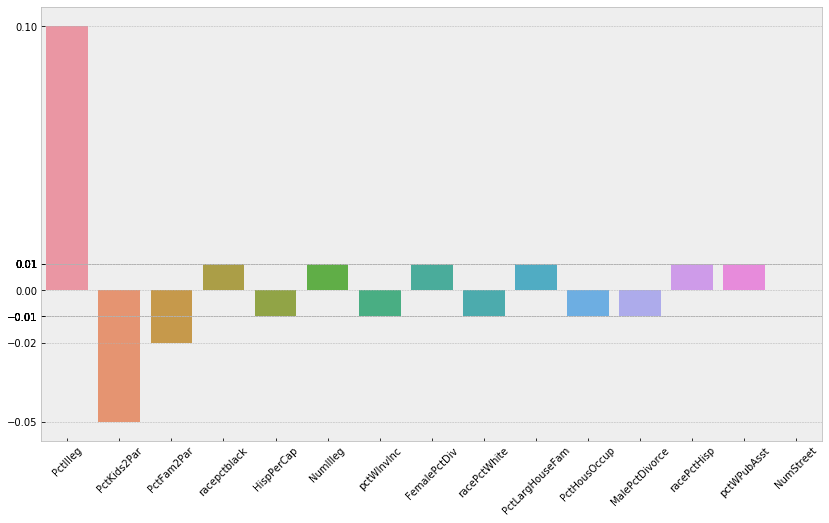

In [141]:
xs = np.arange(len(labels)) 

fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(xs, values, ax=ax)
#plt.bar(xs, values, align='center')
plt.xticks(xs, labels, rotation=45)
plt.yticks(values)
plt.show()

In [142]:
prediction

array([0.2768])

In [143]:
bias

array([0.23680702])

In [144]:
contributions

array([[ 7.92857143e-04,  2.25974026e-04,  1.22441082e-02,
        -7.59723008e-03,  0.00000000e+00,  5.51731558e-03,
         3.94285714e-04,  2.13333333e-04,  2.15252245e-03,
         2.23855011e-03, -3.02760802e-05, -1.19378531e-03,
         7.30769231e-04, -1.07972222e-03, -6.28269758e-04,
        -8.44417128e-03, -1.00000000e-04,  5.07857380e-03,
         1.65049228e-03, -2.04574650e-03, -4.17849685e-03,
        -4.92004227e-05, -1.31717057e-04,  1.29349593e-04,
        -1.96142200e-03, -1.02543816e-02, -3.20098369e-03,
         3.55900805e-03, -4.10568531e-04, -6.04481793e-04,
         7.25000000e-04, -5.73907204e-04,  1.03577291e-03,
        -3.34165546e-04,  9.18667094e-04,  1.23316281e-05,
        -8.57540573e-05, -5.69552412e-03,  1.90441176e-04,
         8.32223398e-03,  2.50781860e-03,  3.79116405e-03,
        -1.65457472e-02, -5.26029324e-02, -1.72463177e-04,
         4.29973007e-03, -1.76181012e-03, -2.91723090e-03,
         8.76709722e-03,  1.01539394e-01, -4.06194170e-0

In [145]:
print(bias + np.sum(contributions, axis=1))

[0.2768]


In [163]:
rf = RandomForestRegressor(random_state=seed, 
                           n_jobs=-1,
                           n_estimators=50,
                           min_samples_leaf=1,
                           min_samples_split=2).fit(top50x, top50y)

In [156]:
estimator = rf.estimators_[5]
estimator1 = rf.estimators_[6]

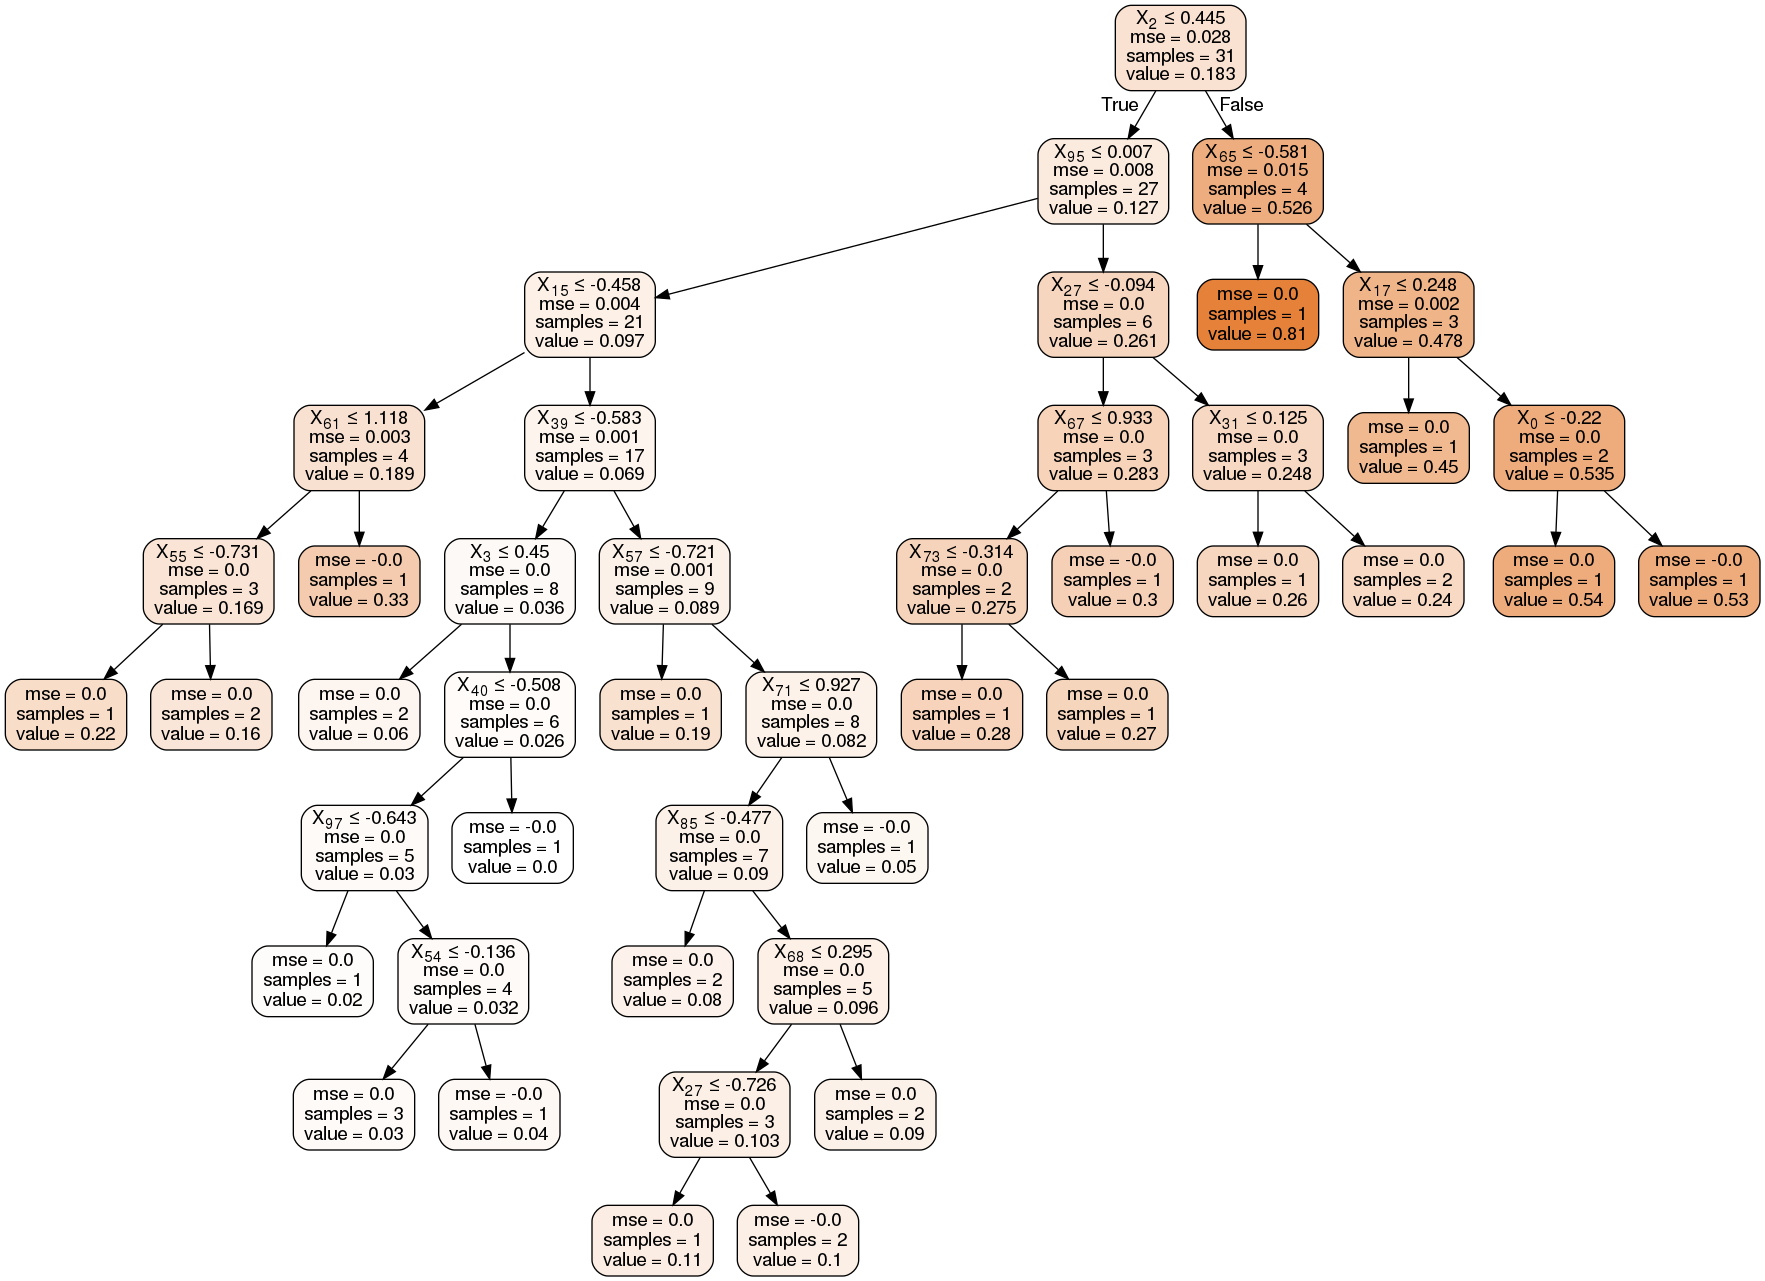

In [165]:
dot_data = StringIO()
export_graphviz(estimator, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Extra Tree Algorithm Tuning

In [57]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)

n_estimators_values=np.array([200,300])
min_samples_split_values = [2,3]
min_samples_leaf_values = [1,10,20]

param_grid = dict(n_estimators=n_estimators_values,
                  min_samples_split=min_samples_split_values, 
                  min_samples_leaf=min_samples_leaf_values)

model = ExtraTreesRegressor(random_state=seed, n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=score, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.652257 using {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 1}
0.648769 (0.035798) with: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 10}
0.649238 (0.044568) with: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1}
0.637509 (0.031734) with: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 20}
0.650044 (0.035852) with: {'n_estimators': 300, 'min_samples_split': 3, 'min_samples_leaf': 10}
0.651283 (0.043520) with: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1}
0.637509 (0.031734) with: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 20}
0.638494 (0.031606) with: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 20}
0.651458 (0.042893) with: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 1}
0.648769 (0.035798) with: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 10}
0.652257 (0.043207) with: {'n_estimators': 300, '

### Optimized Ensembles

In [58]:
ensembles = []
ensembles.append(('Scaled Opt AB', Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor(n_estimators=5))])))
ensembles.append(('Scaled Opt GBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor(n_estimators=60))])))
ensembles.append(('Scaled Opt RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=70, 
                                                                                                        min_samples_split=3,
                                                                                                        min_samples_leaf=10))])))
ensembles.append(('Scaled Opt ET', Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=300, 
                                                                                                      min_samples_split=3,
                                                                                                      min_samples_leaf=1))])))
results_ensembles = []
names_ensembles = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=score)
    results_ensembles.append(cv_results)
    names_ensembles.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Scaled Opt AB: 0.576574 (0.052203)
Scaled Opt GBM: 0.644266 (0.042700)
Scaled Opt RF: 0.636597 (0.034907)
Scaled Opt ET: 0.654117 (0.040296)


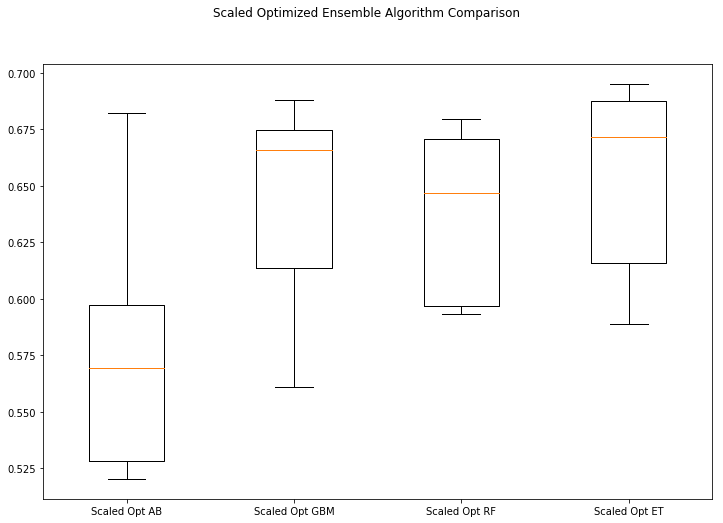

In [59]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('Scaled Optimized Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_ensembles)
ax.set_xticklabels(names_ensembles)
plt.show()

### Summarizing all the optimized results

In [60]:
results_all = results + results_ensembles
names_all = names + names_ensembles

pd.Series([x.mean() for x in results_all], index=names_all).sort_values(ascending=False)

Opt GPR             0.67
Scaled Opt ET       0.65
Scaled Opt RIDGE    0.65
Scaled Opt LASSO    0.65
Scaled RIDGECV      0.65
Scaled Opt GBM      0.64
Scaled LR           0.64
Scaled Opt RF       0.64
Scaled Opt EN       0.63
Scaled SVR          0.60
Scaled Opt KNN      0.60
Scaled Opt AB       0.58
Scaled Opt CART     0.57
Opt MLPR            0.55
dtype: float64

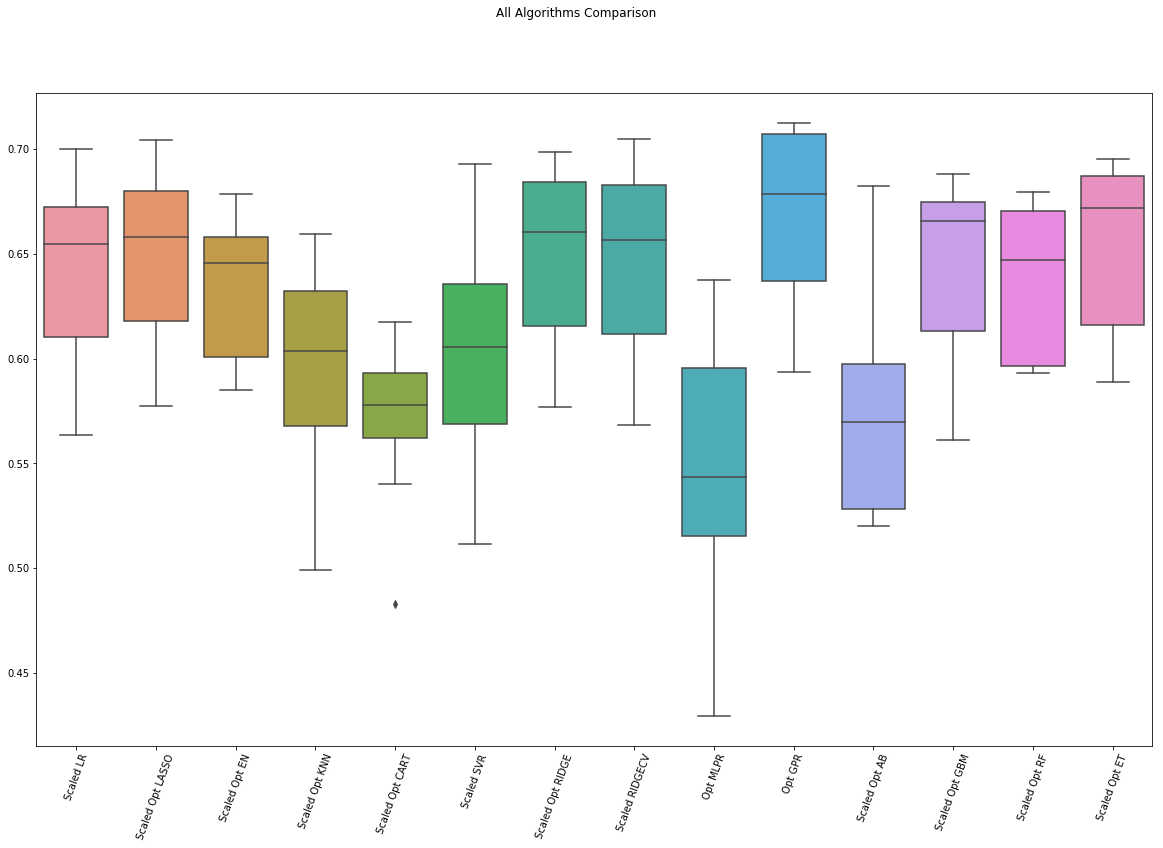

In [61]:
fig = plt.figure(figsize=(20,12))
fig.suptitle('All Algorithms Comparison')
ax = fig.add_subplot(111)
#plt.boxplot(results, widths=0.5)
sns.boxplot(data=results_all)
ax.set_xticklabels(names_all)
plt.xticks(rotation=70)
plt.show()

#### So our best regressors are Gaussian Processes, Extra Trees, Ridge and Lasso

#### Let's examine how Lasso / Ridge / ElasticNet Regularization  
i.e. elimination of irrelevant features setting their coeficients to Zero or close:

In [62]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = Lasso(alpha=0.00145, random_state=seed)
model.fit(rescaledX, Y_train)

Lasso(alpha=0.00145, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
eval = pd.Series(model.coef_, index=df.columns[:-1]).sort_values()
eval

PctKids2Par             -5.26e-02
PctPopUnderPov          -1.83e-02
MedOwnCostPctIncNoMtg   -1.65e-02
pctWInvInc              -1.57e-02
PctWorkMom              -1.39e-02
RentLowQ                -1.18e-02
agePct12t29             -1.17e-02
racePctWhite            -1.05e-02
PctHousOccup            -9.06e-03
pctWRetire              -7.30e-03
PctFam2Par              -6.25e-03
PctWOFullPlumb          -4.24e-03
PctVacMore6Mos          -3.23e-03
NumImmig                -1.98e-03
indianPerCap            -1.88e-03
PctEmplManu             -1.58e-03
MedYrHousBuilt          -1.18e-03
PctYoungKids2Par        -7.03e-04
PctForeignBorn           0.00e+00
RentHighQ                0.00e+00
RentMedian               0.00e+00
PctUsePubTrans           0.00e+00
NumInShelters            0.00e+00
PctImmigRecent           0.00e+00
PctImmigRec5             0.00e+00
PctImmigRec8            -0.00e+00
PctImmigRec10            0.00e+00
PctRecentImmig           0.00e+00
PctRecImmig5             0.00e+00
PctHousOwnOcc 

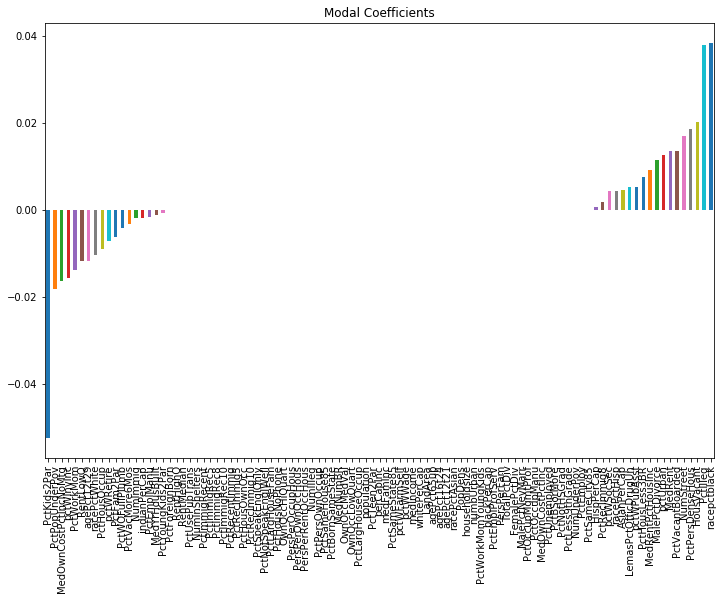

In [64]:
eval.plot(kind='bar', title='Modal Coefficients', figsize=(12,8))

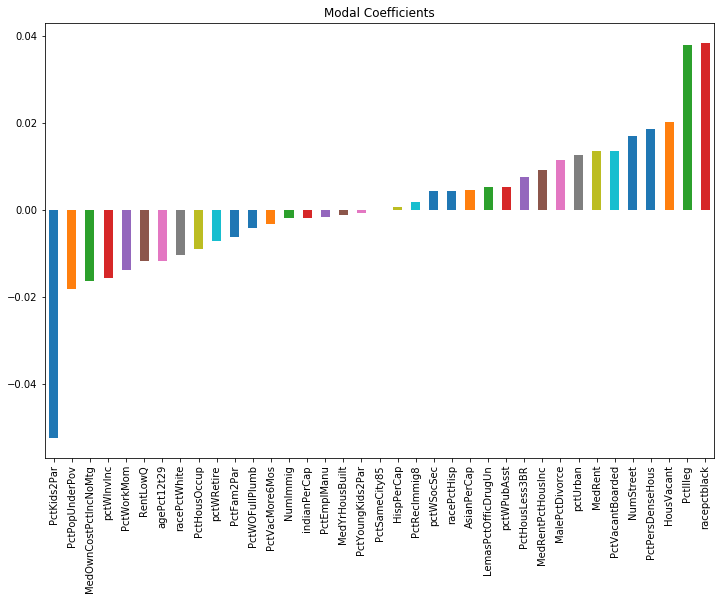

In [65]:
eval2 = eval[np.abs(eval)>1e-6]
eval2.plot(kind='bar', title='Modal Coefficients', figsize=(12,8))

#### Verifying the Lasso and ElasticNet paths

(see pages pages 69-73 from [The Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf)

In [66]:
eps = 5e-3

print("Computing regularization path using the lasso...")
alphas_lasso, coefs_lasso, _ = lasso_path(rescaledX, Y_train, eps, random_state=0)

print("Computing regularization path using the positive lasso...")
alphas_positive_lasso, coefs_positive_lasso, _ = lasso_path(rescaledX, Y_train, eps, positive=True, fit_intercept=False)

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(rescaledX, Y_train, eps=eps, l1_ratio=0.8, fit_intercept=False)

print("Computing regularization path using the positive elastic net...")
alphas_positive_enet, coefs_positive_enet, _ = enet_path(rescaledX, Y_train, eps=eps, l1_ratio=0.8, positive=True, fit_intercept=False)

Computing regularization path using the lasso...
Computing regularization path using the positive lasso...
Computing regularization path using the elastic net...
Computing regularization path using the positive elastic net...


(0.5534468742250752,
 3.1911808837643165,
 -0.07802807201341244,
 0.0499395059969063)

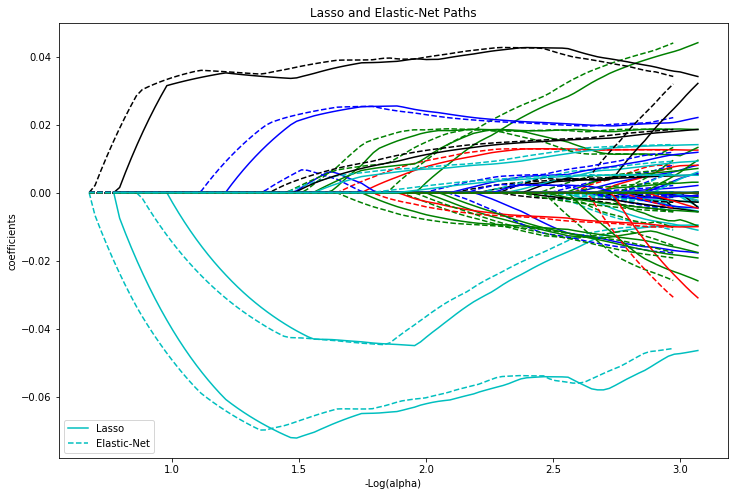

In [67]:
# Display results
plt.figure(figsize=(12,8))
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_lasso = -np.log10(alphas_lasso)
neg_log_alphas_enet = -np.log10(alphas_enet)
for coef_l, coef_e, c in zip(coefs_lasso, coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_enet, coef_e, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and Elastic-Net Paths')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'Elastic-Net'), loc='lower left')
plt.axis('tight')

(0.6552023878835344,
 3.1863353831139136,
 -0.08107456050479377,
 0.11391576431591426)

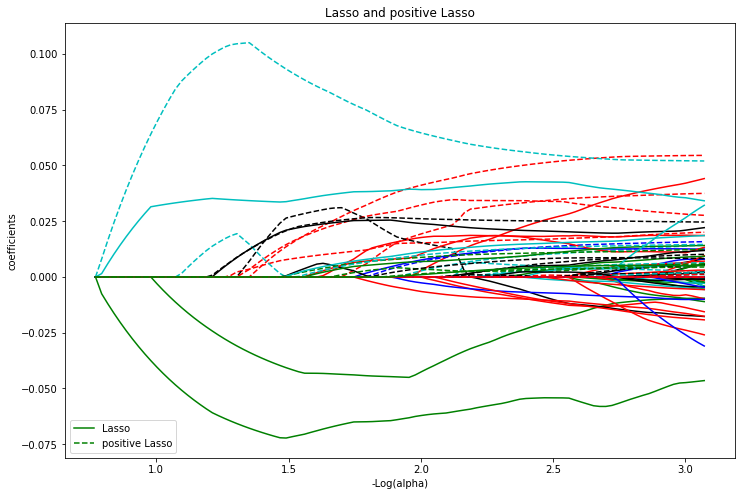

In [68]:
plt.figure(figsize=(12,8))
ax = plt.gca()
neg_log_alphas_positive_lasso = -np.log10(alphas_positive_lasso)
for coef_l, coef_pl, c in zip(coefs_lasso, coefs_positive_lasso, colors):
    l1 = plt.plot(neg_log_alphas_lasso, coef_l, c=c)
    l2 = plt.plot(neg_log_alphas_positive_lasso, coef_pl, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Lasso and positive Lasso')
plt.legend((l1[-1], l2[-1]), ('Lasso', 'positive Lasso'), loc='lower left')
plt.axis('tight')

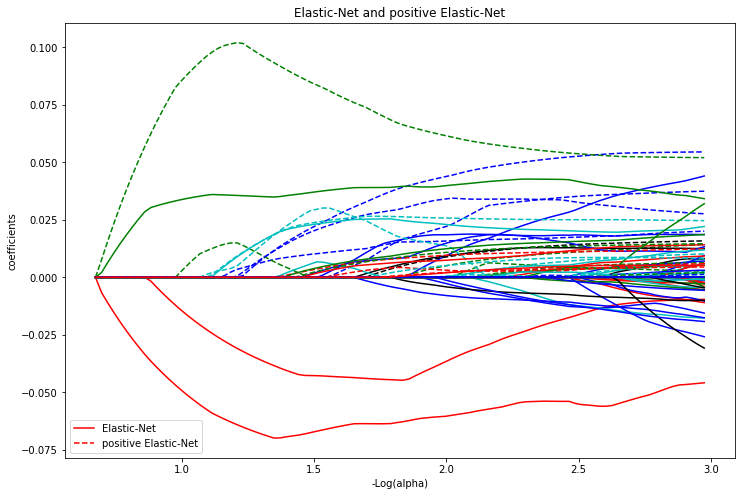

In [69]:
plt.figure(figsize=(12,8))
ax = plt.gca()
neg_log_alphas_positive_enet = -np.log10(alphas_positive_enet)
for (coef_e, coef_pe, c) in zip(coefs_enet, coefs_positive_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, coef_e, c=c)
    l2 = plt.plot(neg_log_alphas_positive_enet, coef_pe, linestyle='--', c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net and positive Elastic-Net')
plt.legend((l1[-1], l2[-1]), ('Elastic-Net', 'positive Elastic-Net'),
           loc='lower left')
plt.axis('tight')
plt.show()

In [70]:
# transform the validation dataset
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = Lasso(alpha=0.00145, random_state=0)
model.fit(rescaledX, Y_train)

rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(Y_validation, predictions))

0.02094980229518499


### Keras Regression

Implementing $R^2$ metric

In [71]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [72]:
# create model
model = Sequential()
model.add(Dense(13, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))

# Compile model
model.compile(optimizer='sgd', loss='mean_squared_error', metrics=[coeff_determination])
model.summary()

# Fit the model
early_stopping = EarlyStopping(monitor='coeff_determination', patience=10)
history =  model.fit(X_train, 
                     Y_train, 
                     epochs=150, 
                     batch_size=50, 
                     verbose=0, 
                     validation_data=(X_validation, Y_validation),) 
#                     callbacks=[early_stopping])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 13)                1300      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 14        
Total params: 1,314
Trainable params: 1,314
Non-trainable params: 0
_________________________________________________________________


In [73]:
hist_df = pd.DataFrame(history.history)
hist_df.tail()

,val_loss,val_coeff_determination,loss,coeff_determination
145,0.02,0.63,0.02,0.65
146,0.02,0.63,0.02,0.65
147,0.02,0.63,0.02,0.65
148,0.02,0.63,0.02,0.65
149,0.02,0.63,0.02,0.65


In [74]:
scores = model.evaluate(X_validation, Y_validation, verbose=1)
print("%s: %.4f%%" % (model.metrics_names[0], scores[0]))
print("%s: %.4f%%" % (model.metrics_names[1], scores[1]))

399/399 [==============================] - 0s 21us/step
loss: 0.0212%
coeff_determination: 0.6250%


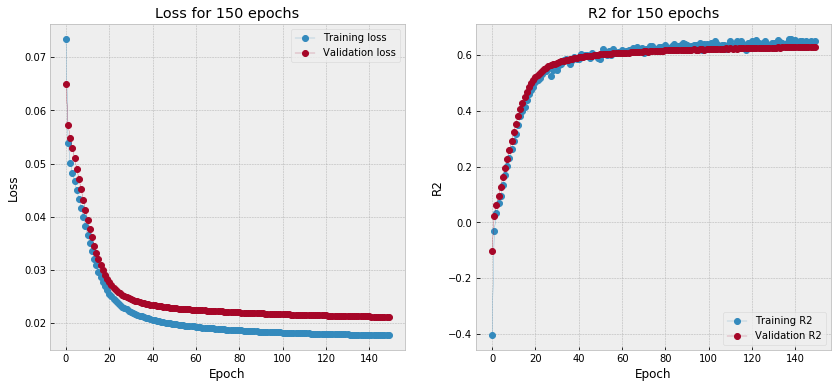

In [75]:
fig = plt.figure(figsize=(14,6))
plt.style.use('bmh')
params_dict = dict(linestyle='solid', linewidth=0.25, marker='o', markersize=6)

plt.subplot(121)
plt.plot(hist_df.loss, label='Training loss', **params_dict)
plt.plot(hist_df.val_loss, label='Validation loss', **params_dict)
plt.title('Loss for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(hist_df.coeff_determination, label='Training R2', **params_dict)
plt.plot(hist_df.val_coeff_determination, label='Validation R2', **params_dict)
plt.title('R2 for ' + str(len(history.epoch)) + ' epochs')
plt.xlabel('Epoch')
plt.ylabel('R2')
plt.legend()

In [76]:
# Making predictions
y_pred = model.predict(X_validation)
y_pred[0:10]

array([[0.09207302],
       [0.11780576],
       [0.22513832],
       [0.0830709 ],
       [0.17473677],
       [0.21139911],
       [0.39660174],
       [0.17871799],
       [0.26747167],
       [0.07862619]], dtype=float32)

In [77]:
# Using k-fold cross validation
i=1
cvscores0 = []
cvscores1 = []
kfold = KFold(n_splits=10, random_state=seed)
for train, validation in kfold.split(X, y):
    # Create model
    model = Sequential()
    model.add(Dense(13, input_dim=X[train].shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(optimizer='sgd', loss='mean_squared_error', metrics=[coeff_determination])
    # Fit the model
    model.fit(X[train], 
              y[train], 
              epochs=150, 
              batch_size=20, 
              verbose=0, 
              validation_data=(X[validation], y[validation]),) 
              #callbacks=[early_stopping])
    # evaluate the model
    print('\nResults from #{} run...'.format(i))
    scores = model.evaluate(X[validation], y[validation], verbose=1)
    print("%s: %.4f%%" % (model.metrics_names[0], scores[0]))
    print("%s: %.4f%%" % (model.metrics_names[1], scores[1]))
    cvscores0.append(scores[0])
    cvscores1.append(scores[1])
    i+=1
model.summary()
print("%.2f%% (+/- %.4f%%)" % (np.mean(cvscores0), np.std(cvscores0)))
print("%.2f%% (+/- %.4f%%)" % (np.mean(cvscores1), np.std(cvscores1)))


Results from #1 run...
200/200 [==============================] - 0s 39us/step
loss: 0.0213%
coeff_determination: 0.6205%

Results from #2 run...
200/200 [==============================] - 0s 27us/step
loss: 0.0195%
coeff_determination: 0.5643%

Results from #3 run...
200/200 [==============================] - 0s 31us/step
loss: 0.0251%
coeff_determination: 0.4487%

Results from #4 run...
200/200 [==============================] - 0s 27us/step
loss: 0.0201%
coeff_determination: 0.5920%

Results from #5 run...
199/199 [==============================] - 0s 30us/step
loss: 0.0178%
coeff_determination: 0.6944%

Results from #6 run...
199/199 [==============================] - 0s 27us/step
loss: 0.0154%
coeff_determination: 0.7104%

Results from #7 run...
199/199 [==============================] - 0s 28us/step
loss: 0.0155%
coeff_determination: 0.7048%

Results from #8 run...
199/199 [==============================] - 0s 27us/step
loss: 0.0160%
coeff_determination: 0.6096%

Results from #9